# OpenCV for Optical Flow

ここでは、OpenCVで[Lucas–Kanade法](https://en.wikipedia.org/wiki/Lucas%E2%80%93Kanade_method)を用いたOptical Flowの検出を行ってみたいと思います。


In [1]:
# enable showing matplotlib image inline
%matplotlib inline
%matplotlib nbagg

import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.animation as animation

VIDEO_PATH = "./video/domo_running.mp4"

# params for ShiTomasi corner detection
FEATURE_COUNT = 100
FEATURE_PARAMS = dict(
    maxCorners=FEATURE_COUNT,
    qualityLevel=0.3,
    minDistance=7,
    blockSize=7
)

# Parameters for lucas kanade optical flow
LK_PARAMS = dict(
    winSize  = (15,15),
    maxLevel = 2,
    criteria = (cv2.TERM_CRITERIA_COUNT | cv2.TERM_CRITERIA_EPS, FEATURE_COUNT, 0.03)
)

# color for drawing (create FEATURE_COUNT colors each of these is RGB color)
COLOR = np.random.randint(0, 255,(FEATURE_COUNT, 3))


C:\Users\ico\Documents\env\Miniconda3\envs\cv_env\lib\site-packages\IPython\kernel\__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


In [2]:
def frames():
    """
    Get frames from video
    """

    video = cv2.VideoCapture(VIDEO_PATH)
    success = True

    while(success):
        success, current = video.read()
        if not success:
            break
        yield current
    else:
        video.release()


def optical_flow():
    """
    Detect and Draw Optical Flow
    """

    get_features = lambda f: cv2.goodFeaturesToTrack(f, mask=None, **FEATURE_PARAMS)
    to_grayscale = lambda f: cv2.cvtColor(f, cv2.COLOR_BGR2GRAY)
    
    previous_is_set = False
    p_frame = None
    p_features = []
    mask = []
    
    for frame in frames():
        glayed = to_grayscale(frame)

        if not previous_is_set:
            p_frame = glayed
            p_features = get_features(p_frame)
            mask = np.zeros_like(frame)

            if p_features is not None:
                previous_is_set = True
            else:
                continue

        else:
            # calculate optical flow
            c_features, st, err = cv2.calcOpticalFlowPyrLK(p_frame, glayed, p_features, None, **LK_PARAMS)
        
            if c_features is None:
                continue
            else:
                # select good points (st = 1 if tracking is successed)
                tracked = c_features[st==1]
                tracked_in_previous = p_features[st==1]

                # draw line
                for i,(current, previous) in enumerate(zip(tracked, tracked_in_previous)):
                    x1, y1 = current.ravel()
                    x0, y0 = previous.ravel()
                    mask = cv2.line(mask, (x1, y1), (x0, y0), COLOR[i].tolist(), 2)
                    frame = cv2.circle(frame, (x1, y1), 5, COLOR[i].tolist(), -1)
                
                img = cv2.add(frame, mask)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # OpenCV has color BGR
                yield img
                
                p_frame = glayed.copy()
                p_features = c_features.reshape(-1, 1, 2)


<IPython.core.display.Javascript object>


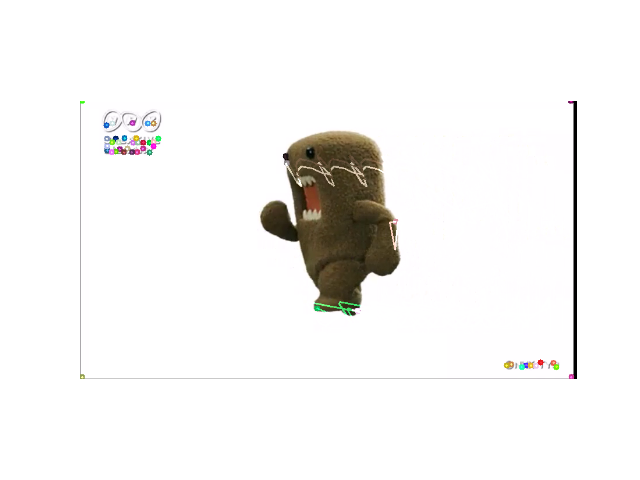

In [3]:
def draw():
    fig = plt.figure()
    ims = []

    for f in optical_flow():
        ims.append([plt.imshow(f)])

    ani = animation.ArtistAnimation(fig, ims)
    plt.axis("off")
    plt.show()

draw()